<a href="https://colab.research.google.com/github/IaroslavS/blur_classification/blob/master/blur_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from skimage.io import imshow, show
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import pylab
import math
import numpy as np
from skimage.color import rgb2gray, gray2rgb
from tqdm import tqdm_notebook, tqdm
import pandas as pd
import cv2
import os
import PIL

In [0]:
IMAGE_DIMS = (512, 512, 1)
input_dir_images_for_blurring = '/content/drive/My Drive/24 images from Chochia/cropped_and_resized'
output_dir_images_for_blurring = '/content/drive/My Drive/Datasets/Spectres_of_Gauss_blurred_Chochia_images_0_1'
dir_with_non_blurred_images = '/content/drive/My Drive/Datasets/Non-blurred-images'
flag_look_for_spectres_instead_of_images = False
flag_make_log_pixels = False

In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="all"

## Defining blur kernels

In [0]:
def h_circular_scattering(x, y, param1=20, param2 = None, x_c = None, y_c = None):
  r = param1
  x = x - x_c
  y = y - y_c
  result = 0
  if (x*x + y*y) <= r*r:
    result = 1/(math.pi*(r*r))
  return result

def h_Gauss(x, y, C=1, param1=10, param2 = None, x_c = None, y_c = None):
  sigma = param1
  x = x - x_c
  y = y - y_c
  return (C * (math.e ** ( -(x**2 + y**2)/(2*(sigma**2))) ))

def h_linear_smearing(x,y, param1=32, param2 = 0, x_c = None, y_c = None):
  r = param1
  alpha = param2
  if abs(alpha) > 45: alpha = -math.copysign(90-abs(alpha), alpha)
  x = x - x_c
  y = -y + y_c
  D = r - (x**2 + y**2) ** 0.5
  distance_r = (x**2 + y**2) ** 0.5
  alpha = math.radians(alpha)
  result = 0
  if ( (x**2 + y**2) <= ((r**2)/4) ) and ( y == int(round(x*math.tan(alpha),0)) ):
    result = 1
  return result

## Creating the blur function for given image, type of blur and parameters of the kernel blur

In [0]:
def blur(_image, kernel_blur, param1, param2):

  # creating samples from the kernel blur---------------------------------------------------------------------------
  v = np.zeros((_image.shape[0],_image.shape[1]))
  for i in range(_image.shape[0]):
    for j in range(_image.shape[1]):
      v[i][j] = kernel_blur(j, i, param1=param1, param2=param2, x_c = (_image.shape[1] // 2), y_c = (_image.shape[0] // 2))
  v = np.reshape(v,-1)
  v = v/np.sum(v) # Normalizing the sample matrix of the kernel blur. The sum of the elements of the matrix will be equal to one
  #----------------------------------------------------------------------------------------------------------------------

  #--------------------------------------------------------
  if (kernel_blur == h_linear_smearing) and (abs(param2) > 45):
    _image = np.transpose(_image[::-1])
  #--------------------------------------------------------

  #------Fourier Transform---------------------------------
  F_image = np.fft.fft(np.reshape(_image,(1,-1)))
  F_h = np.fft.fft(np.reshape(v,-1))
  #--------------------------------------------------------

  #--We take only the amplitudes from the Fourier image-----
  F_h = np.reshape(F_h, -1)
  for i in range(F_h.shape[-1]):
    F_h[i] = abs(F_h[i])
  #--------------------------------------------------------

  F = F_h*F_image # Multiply the Fourier transform of the image with the Fourier transform of the kernel blur (see convolution theorem)
  f = np.fft.ifft(F) # Inverse fourier transform
  f = np.reshape(f,_image.shape)

  if (kernel_blur == h_linear_smearing) and (abs(param2) > 45):
    f = np.transpose(f)[::-1]

  f_real = np.zeros(f.shape, dtype=float)
  for i in range(f.shape[0]):
    for j in range(f.shape[1]):
      f_real[i][j] = abs(f[i][j])
  return f_real

# Obtaining a picture of the amplitude of the spectrum of a blurred image

In [0]:
def get_pic_FT(_image):
  F_image = np.fft.fft(np.reshape(_image,(1,-1)))
  temp_F = np.copy(F_image)
  temp_F = np.reshape(temp_F, _image.shape)
  temp = np.zeros(temp_F.shape, dtype=float)
  temp = np.reshape(temp, _image.shape)
  for i in range(temp_F.shape[0]):
    k = i + temp_F.shape[0] // 2
    if k > (temp_F.shape[0]-1): k = i - temp_F.shape[0] // 2
    for j in range(temp_F.shape[1]):
      l = j + temp_F.shape[1] // 2
      if l > (temp_F.shape[1]-1): l = j - temp_F.shape[1] // 2
      temp[i][j] = abs(temp_F[k][l])
  return temp

# Creating dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# The choice of blurrings: h_linear_smearing ,h_Gauss, h_circular_scattering
functions = [h_Gauss]

In [0]:
def blur_and_save_from_one_image(_image, _filename, make_log_pixels=False, look_for_spectres_instead_of_images=False):
  for function in functions:
    num_images_for_one_blur = len(np.arange(2,int(_image.shape[0]*0.15)))
    fname = _filename[:_filename.rfind('.')]
    if function == h_linear_smearing: fname += '_linear smearing'
    elif function == h_circular_scattering: fname += '_circular scattering'
    elif function == h_Gauss: fname += '_Gauss'
    if function == h_circular_scattering:
      radiuses = np.arange(2,int(_image.shape[0]*0.15))
      param1 = radiuses
      param2 = None
    if function == h_Gauss:
      sigmas = np.linspace(0.01, 1, 100)
      param1 = sigmas
      param2 = None
    if function == h_linear_smearing:
      radiuses = np.linspace(2,_image.shape[0]*0.15, int(num_images_for_one_blur ** 0.5))
      alpha_upper = 90.0
      alpha_lower = -89.0
      alphas = np.linspace(alpha_lower, alpha_upper, 180)
      param1 = radiuses
      param2 = alphas
    for parameter_1 in param1:

      if type(param2) == type(np.arange(0.1,0.2,0.1)):
        for parameter_2 in param2:
          image_new = blur(_image, function, param1=parameter_1, param2=parameter_2)
          if look_for_spectres_instead_of_images: image_new = get_pic_FT(image_new)
          if make_log_pixels:
            image_new = np.reshape(image_new,(-1))
            for i in range(len(image_new)):
              if image_new[i] != 0:
                image_new[i] = math.log(image_new[i])
            image_new = np.reshape(image_new,_image.shape)
          image_new = (image_new - np.min(image_new))/(np.max(image_new)-np.min(image_new))
          image_new = image_new*255
          image_output = image_new.astype(np.uint8)
          fname = _filename[:_filename.rfind('.')]
          if function == h_linear_smearing: fname += '_linear smearing'
          elif function == h_circular_scattering: fname += '_circular scattering'
          elif function == h_Gauss: fname += '_Gauss'
          fname += '_' + str(parameter_1) + '_' + str(parameter_2)
          array_to_file.append([fname+'.png', fname.split('_')[-3], fname.split('_')[-2], fname.split('_')[-1][:fname.rfind('.')], _filename[:_filename.rfind('.')]])
          if flag_look_for_spectres_instead_of_images and flag_make_log_pixels:
            image_output = image_output[128:384,128:384]
          imsave(output_dir_images_for_blurring+'/'+_filename[:_filename.rfind('.')] +'/'+fname+'.png', image_output)
      elif type(param2) == type(None):
        image_new = blur(_image, function, param1=parameter_1, param2=None)
        if look_for_spectres_instead_of_images: image_new = get_pic_FT(image_new)
        if make_log_pixels:
          image_new = np.reshape(image_new,(-1))
          for i in range(len(image_new)):
            if image_new[i] != 0:
              image_new[i] = math.log(image_new[i])
          image_new = np.reshape(image_new,_image.shape)
        image_new = (image_new - np.min(image_new))/(np.max(image_new)-np.min(image_new))
        image_new = image_new*255
        image_output = image_new.astype(np.uint8)
        fname = _filename[:_filename.rfind('.')]
        if function == h_linear_smearing: fname += '_linear smearing'
        elif function == h_circular_scattering: fname += '_circular scattering'
        elif function == h_Gauss: fname += '_Gauss'
        fname += '_' + str(parameter_1) + '_' + str(param2)
        array_to_file.append([fname+'.png', fname.split('_')[-3], fname.split('_')[-2], fname.split('_')[-1][:fname.rfind('.')], _filename[:_filename.rfind('.')]])
        if flag_look_for_spectres_instead_of_images and flag_make_log_pixels:
          image_output = image_output[128:384,128:384]
        imsave(output_dir_images_for_blurring+'/'+_filename[:_filename.rfind('.')] +'/'+fname+'.png', image_output)

In [0]:
for filename in os.listdir(dir_with_non_blurred_images):
  if filename.find('None') == -1:
    os.rename(dir_with_non_blurred_images+'/'+filename, dir_with_non_blurred_images+'/'+filename.replace('_','-')[:filename.rfind('.')]+'_None_None_None'+filename[filename.rfind('.'):])

FileNotFoundError: ignored

In [0]:
array_to_file = []
for filename in tqdm_notebook(os.listdir(input_dir_images_for_blurring)):
  if filename.find('.png') == -1:
    continue
  if filename[:filename.rfind('.')] in os.listdir('/content/drive/My Drive/Datasets/Spectres_of_Gauss_blurred_Chochia_images_0_1'):
    continue
  if os.path.isdir(output_dir_images_for_blurring+'/'+filename[:filename.rfind('.')]) == False:
    os.makedirs(output_dir_images_for_blurring+'/'+filename[:filename.rfind('.')], exist_ok=True)
  image_PIL = PIL.Image.open(input_dir_images_for_blurring+'/'+filename).convert('RGB')
  image_PIL = image_PIL.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
  image_cv = np.array(image_PIL)
  image_gray = rgb2gray(image_cv)
  input_image_for_dataset = image_gray
  blur_and_save_from_one_image(input_image_for_dataset, filename, make_log_pixels=flag_make_log_pixels,
                               look_for_spectres_instead_of_images=flag_look_for_spectres_instead_of_images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
if not(os.path.isdir(output_dir_images_for_blurring+'/Non-blurred-images')):
  os.mkdir(output_dir_images_for_blurring+'/Non-blurred-images')
for filename in tqdm_notebook(os.listdir(dir_with_non_blurred_images)):
  image_PIL = PIL.Image.open(dir_with_non_blurred_images+'/'+filename).convert('RGB')
  image_PIL = image_PIL.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
  image_cv = np.array(image_PIL)
  image_gray = rgb2gray(image_cv)
  image_new = np.copy(image_gray)
  if flag_look_for_spectres_instead_of_images:
    image_new = get_pic_FT(image_new)
  if flag_make_log_pixels:
    image_new = np.reshape(image_new,(-1))
    for i in range(len(image_new)):
      if image_new[i] != 0:
        image_new[i] = math.log(image_new[i])
    image_new = np.reshape(image_new,image_gray.shape)
  image_new = (image_new - np.min(image_new))/(np.max(image_new) - np.min(image_new))
  image_new = image_new*255
  image_new = image_new.astype('uint8')
  image_output = image_new
  imsave(output_dir_images_for_blurring+'/Non-blurred-images/'+filename, image_output)

In [0]:
# Saving to csv file 'dataset_csv'
pd.DataFrame(array_to_file).to_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv', index=False)

In [0]:
data_frame = pd.read_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv')

In [0]:
import os
# Looking for images in folders that are not listed in the .csv file and write them to the .csv file
data_frame = pd.read_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv')
for dir_path_images in tqdm_notebook(os.listdir(output_dir_images_for_blurring)):
  if dir_path_images == 'logs':
    continue
  if dir_path_images.find('.') == -1:
    for fname in os.listdir(output_dir_images_for_blurring+'/'+dir_path_images):
      if not (fname in [x for x in data_frame['0']]):
        a = []
        a += [fname]
        a += [fname.split('_')[-3]]
        a += [fname.split('_')[-2]]
        temp = fname.split('_')[-1]
        temp = temp[:temp.rfind('.')]
        a += [temp]
        a += [dir_path_images]
        a = np.reshape(np.array(a), (1,-1))
        a = pd.DataFrame(a,columns=['0','1','2','3','4'])
        data_frame = pd.concat([data_frame, a])

# deleting records for which there is actually no image
# flag = True
# while flag:
#   flag = True
#   for i in range(len(data_frame)):
#     for dir_path_images in os.listdir(output_dir_images_for_blurring):
#       if dir_path_images.find('.') == -1:
#         if os.listdir(output_dir_images_for_blurring+'/'+dir_path_images).count(data_frame.iloc[i][0]) != 0:
#           flag = False
#           break
#     if flag:
#       data_frame = data_frame.drop(index=i)
#     if flag:
#       break

# saving to csv file 'dataset_csv'
data_frame = data_frame.sort_values(['1'])
pd.DataFrame(data_frame).to_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
for i in range(len(data_frame)):
  if data_frame.iloc[i,0].find('(') != -1:
    print(data_frame.iloc[i,0])

# Training ResNet29 on blurred images from 20 original images

In [0]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

import numpy as np
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from PIL import Image

from keras import backend as K

In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Dataset_of_blurred_images'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
EPOCHS = 200
INIT_LR = 1e-5 # initial learning rate
BS = 64 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet29(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [0]:
resnet29_model_for_blurred_images = ResNet29(input_tensor=None, input_shape=None,
             pooling=None,
             classes=4)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet29_model_for_blurred_images.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training ResNet18 on blurred images from 20 original images

Implementation of ResNet adapted from: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/applications/resnet.py

In [0]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

from __future__ import division

import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape

from keras import backend as K

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Dataset_of_blurred_images'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
EPOCHS = 100
INIT_LR = 1e-5 # initial learning rate
BS = 64 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model

def ResNet18(input_shape, classes):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])

In [0]:
resnet18_model_for_blurred_images = ResNet18(input_shape=(512,512,3), classes=4)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet18_model_for_blurred_images.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])













reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(512, 512),
        batch_size=BS,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(512, 512),
        batch_size=BS,
        class_mode='categorical')

Found 3215 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet18-blur-classification-blurred-images-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
H=resnet18_model_for_blurred_images.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)



Epoch 1/100
51/51 [==============================] - 57s 1s/step - loss: 1.3576 - acc: 0.8043 - val_loss: 1.3180 - val_acc: 0.8237

Epoch 00001: val_acc improved from -inf to 0.82373, saving model to /content/drive/My Drive/Datasets/Dataset_of_blurred_images/weights-resnet18-blur-classification-blurred-images-01-0.82.hdf5
Epoch 2/100
51/51 [==============================] - 31s 608ms/step - loss: 1.2782 - acc: 0.8471 - val_loss: 1.3030 - val_acc: 0.8234

Epoch 00002: val_acc did not improve from 0.82373
Epoch 3/100
51/51 [==============================] - 37s 726ms/step - loss: 1.2419 - acc: 0.8706 - val_loss: 1.2603 - val_acc: 0.8494

Epoch 00003: val_acc improved from 0.82373 to 0.84944, saving model to /content/drive/My Drive/Datasets/Dataset_of_blurred_images/weights-resnet18-blur-classification-blurred-images-03-0.85.hdf5
Epoch 4/100
51/51 [==============================] - 37s 734ms/step - loss: 1.2124 - acc: 0.8825 - val_loss: 1.3632 - val_acc: 0.8274

Epoch 00004: val_acc did

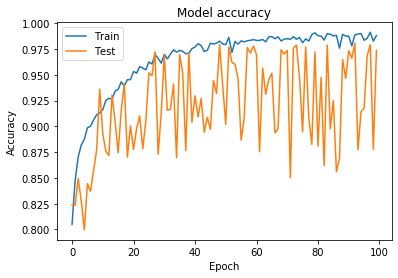

In [0]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

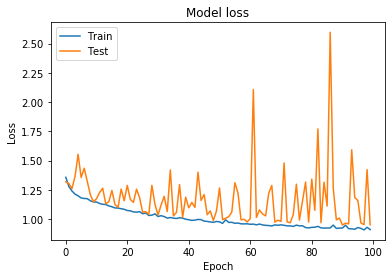

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
np.max(H.history['val_acc'])

0.9807930600539755

# Training on spectres of blurred images

In [0]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

import numpy as np
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from PIL import Image

from keras import backend as K

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Dataset_of_spectres_of_blurred_images'

In [0]:
EPOCHS = 200
INIT_LR = 1e-5 # initial learning rate
BS = 64 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

In [0]:
for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50_cut(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [0]:
resnet50_model_for_spectres = ResNet50_cut(input_tensor=None, input_shape=None,
             pooling=None,
             classes=4)

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet50_model_for_spectres.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

Found 2261 validated image filenames belonging to 4 classes.
Found 566 validated image filenames belonging to 4 classes.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet50-blur-classification-spectres-of-images-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
H=resnet50_model_for_spectres.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/200
36/36 [==============================] - 679s 19s/step - loss: 0.4456 - acc: 0.7968 - val_loss: 0.4327 - val_acc: 0.8083

Epoch 00001: val_acc improved from -inf to 0.80830, saving model to /content/drive/My Drive/Datasets/Dataset_of_spectres_of_blurred_images/weights-resnet50-blur-classification-spectres-of-images-01-0.81.hdf5
Epoch 2/200
36/36 [==============================] - 42s 1s/step - loss: 0.2787 - acc: 0.8703 - val_loss: 0.4581 - val_acc: 0.7761

Epoch 00002: val_acc did not improve from 0.80830
Epoch 3/200
36/36 [==============================] - 50s 1s/step - loss: 0.2503 - acc: 0.8894 - val_loss: 0.6424 - val_acc: 0.7412

Epoch 00003: val_acc did not improve from 0.80830
Epoch 4/200
36/36 [==============================] - 50s 1s/step - loss: 0.2275 - acc: 0.8983 - val_loss: 0.7300 - val_acc: 0.7420

Epoch 00004: val_acc did not improve from 0.80830
Epoch 5/200
36/36 [==============================] - 50s 1s/step - loss: 0.2112 - acc: 0.9130 - val_loss: 0.6787

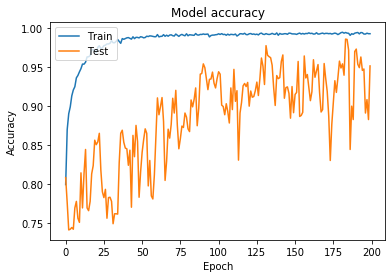

In [0]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

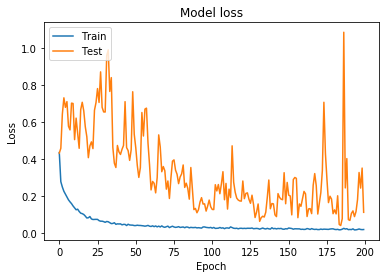

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
np.max(H.history['val_acc'])

0.9863074181779113

In [0]:
H.history['val_loss'][np.argmax(H.history['val_acc'])]

0.04820064552681185

In [0]:
np.min(H.history['val_loss'])

0.0423844478787466

# Training on naturally blurred  images

In [0]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

import numpy as np
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from PIL import Image

from keras import backend as K

In [0]:
# Looking for images in folders that are not listed in the .csv file and write them to the .csv file

output_dir_images_for_blurring = '/content/drive/My Drive/Datasets/Naturally blurred images/for_training'

data_frame = pd.read_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv')
for dir_path_images in tqdm_notebook(os.listdir(output_dir_images_for_blurring)):
  if dir_path_images.find('.') == -1:
    for fname in os.listdir(output_dir_images_for_blurring+'/'+dir_path_images):
      if not (fname in [x for x in data_frame['0']]):
        a = []
        a += [fname]
        a += [fname.split('_')[-3]]
        a += [fname.split('_')[-2]]
        temp = fname.split('_')[-1]
        temp = temp[:temp.rfind('.')]
        a += [temp]
        a += [dir_path_images]
        a = np.reshape(np.array(a), (1,-1))
        a = pd.DataFrame(a,columns=['0','1','2','3','4'])
        data_frame = pd.concat([data_frame, a])

# # deleting records for which there is actually no image
# flag = True
# while flag:
#   flag = True
#   for i in range(len(data_frame)):
#     for dir_path_images in os.listdir(output_dir_images_for_blurring):
#       if dir_path_images.find('.') == -1:
#         if os.listdir(output_dir_images_for_blurring+'/'+dir_path_images).count(data_frame.iloc[i][0]) != 0:
#           flag = False
#           break
#     if flag:
#       data_frame = data_frame.drop(index=data_frame.index[i])
#     if flag:
#       break

# saving to csv file 'dataset_csv'
data_frame = data_frame.sort_values(['1'])
pd.DataFrame(data_frame).to_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv', index=False)

In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Naturally blurred images/for_training'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
fname = '/content/drive/My Drive/Datasets/Naturally blurred images/for_training/circular scattering/IMG_2534_0000_circular scattering_None_None.png'
a = fname.split('_')[-1]
a[:a.rfind('.')]

'None'

In [0]:
EPOCHS = 200
INIT_LR = 1e-5 # initial learning rate
BS = 64 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet29(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [0]:
resnet29_model_for_naturally_blurred_images = ResNet29(input_tensor=None, input_shape=None,
             pooling=None,
             classes=3)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet29_model_for_naturally_blurred_images.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

Found 1776 validated image filenames belonging to 3 classes.
Found 444 validated image filenames belonging to 3 classes.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet29-blur-classification-naturally-blurred-images-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
H=resnet29_model_for_naturally_blurred_images.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/200


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/28 [=>............................] - ETA: 15:35 - loss: 0.7700 - acc: 0.5729

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/28 [===>..........................] - ETA: 14:02 - loss: 0.7694 - acc: 0.5729

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


KeyboardInterrupt: ignored

In [0]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
np.max(H.history['val_acc'])

# Training ResNet34 for circular scattering parameters regression






In [0]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

from __future__ import division

import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape

from keras import backend as K

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_circular_scattering'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
EPOCHS = 100
INIT_LR = 1e-5 # initial learning rate
BS = 32 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
dataframe = dataframe.loc[dataframe['1']=='circular scattering']

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation='relu',
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation='linear',
                  kernel_initializer="he_normal")(x)
        # x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model

def ResNet18(input_shape, classes=10, final_pooling='None', top='classification'):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2], final_pooling='None', top=top)


def ResNet34(input_shape, classes=7, final_pooling='None', top='classification'):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3], final_pooling='None', top=top)


def ResNet50(input_shape, classes=10, final_pooling='None', top='classification'):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3], final_pooling='None', top=top)

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

In [0]:
resnet34 = ResNet34(input_shape=(512,512,1),classes=1, top='classification')

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet34.compile(optimizer=opt,
              loss=mean_relative_error,
              metrics=[mean_relative_error])













reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...



In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(512, 512),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(512, 512),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

Found 37272 validated image filenames.
Found 9318 validated image filenames.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet50-blur-regression-circular-scattering-{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
H=resnet50.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/100
52/52 [==============================] - 18s 354ms/step - loss: 30.8839 - mean_absolute_error: 25.6084 - val_loss: 29.5819 - val_mean_absolute_error: 24.3079

Epoch 00001: val_mean_absolute_error improved from inf to 24.30792, saving model to /content/drive/My Drive/Datasets/Dataset_of_blurred_images_from_photos/weights-resnet50-blur-regression-circular-scattering-01-24.31.hdf5
Epoch 2/100
52/52 [==============================] - 19s 358ms/step - loss: 30.4330 - mean_absolute_error: 25.1605 - val_loss: 30.4909 - val_mean_absolute_error: 25.2200

Epoch 00002: val_mean_absolute_error did not improve from 24.30792
Epoch 3/100
52/52 [==============================] - 18s 352ms/step - loss: 29.8466 - mean_absolute_error: 24.5773 - val_loss: 28.8661 - val_mean_absolute_error: 23.5984

Epoch 00003: val_mean_absolute_error improved from 24.30792 to 23.59836, saving model to /content/drive/My Drive/Datasets/Dataset_of_blurred_images_from_photos/weights-resnet50-blur-regression-circu

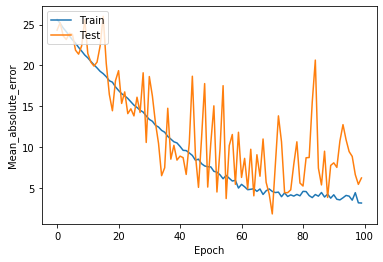

In [0]:
# Plot training & validation accuracy values
plt.plot(H.history['mean_absolute_error'])
plt.plot(H.history['val_mean_absolute_error'])
plt.ylabel('Mean_absolute_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

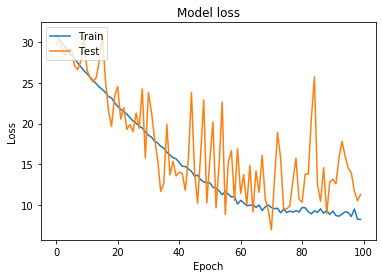

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
np.max(H.history['val_acc'])

# Training for circular scattering parameters regression

In [0]:
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import math

import shutil



# from __future__ import division

import six
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils.generic_utils import get_custom_objects

from keras_applications.imagenet_utils import _obtain_input_shape

import tensorflow as tf
import datetime

Using TensorFlow backend.


In [0]:
def custom_activation(x):
    return K.log(K.abs(x) +10e-10)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [0]:
"""ResNet, ResNetV2, and ResNeXt models for Keras.
# Reference papers
- [Deep Residual Learning for Image Recognition]
  (https://arxiv.org/abs/1512.03385) (CVPR 2016 Best Paper Award)
- [Identity Mappings in Deep Residual Networks]
  (https://arxiv.org/abs/1603.05027) (ECCV 2016)
- [Aggregated Residual Transformations for Deep Neural Networks]
  (https://arxiv.org/abs/1611.05431) (CVPR 2017)
# Reference implementations
- [TensorNets]
  (https://github.com/taehoonlee/tensornets/blob/master/tensornets/resnets.py)
- [Caffe ResNet]
  (https://github.com/KaimingHe/deep-residual-networks/tree/master/prototxt)
- [Torch ResNetV2]
  (https://github.com/facebook/fb.resnet.torch/blob/master/models/preresnet.lua)
- [Torch ResNeXt]
  (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
"""

backend = keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils

_KERAS_BACKEND = keras.backend
_KERAS_LAYERS = keras.layers
_KERAS_MODELS = keras.models
_KERAS_UTILS = keras.utils

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def block1(x, filters, kernel_size=3, stride=1,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
    return x

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x

def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def block3(x, filters, kernel_size=3, stride=1, groups=32,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        groups: default 32, group size for grouped convolution.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D((64 // groups) * filters, 1, strides=stride,
                                 use_bias=False, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    c = filters // groups
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, depth_multiplier=c,
                               use_bias=False, name=name + '_2_conv')(x)
    kernel = np.zeros((1, 1, filters * c, filters), dtype=np.float32)
    for i in range(filters):
        start = (i // c) * c * c + i % c
        end = start + c * c
        kernel[:, :, start:end:c, i] = 1.
    x = layers.Conv2D(filters, 1, use_bias=False, trainable=False,
                      kernel_initializer={'class_name': 'Constant',
                                          'config': {'value': kernel}},
                      name=name + '_2_gconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D((64 // groups) * filters, 1,
                      use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack3(x, filters, blocks, stride1=2, groups=32, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        groups: default 32, group size for grouped convolution.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block3(x, filters, groups=groups, conv_shortcut=False,
                   name=name + '_block' + str(i))
    return x

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='relu', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        by_name = True if 'resnext' in model_name else False
        model.load_weights(weights_path, by_name=by_name)
    elif weights is not None:
        model.load_weights(weights)

    return model

def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 6, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 23, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 8, name='conv3')
        x = stack1(x, 256, 36, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet152',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 23, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet101v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 8, name='conv3')
        x = stack2(x, 256, 36, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet152v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt50(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 6, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt101(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 23, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

setattr(ResNet50, '__doc__', ResNet.__doc__)
setattr(ResNet101, '__doc__', ResNet.__doc__)
setattr(ResNet152, '__doc__', ResNet.__doc__)
setattr(ResNet50V2, '__doc__', ResNet.__doc__)
setattr(ResNet101V2, '__doc__', ResNet.__doc__)
setattr(ResNet152V2, '__doc__', ResNet.__doc__)
setattr(ResNeXt50, '__doc__', ResNet.__doc__)
setattr(ResNeXt101, '__doc__', ResNet.__doc__)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_circular_scattering'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
EPOCHS = 100
INIT_LR = 1e-5 # initial learning rate
BS = 8 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
dataframe = dataframe.loc[dataframe['1']=='circular scattering']

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

In [0]:
resnext50 = ResNeXt50(input_shape=(512,512,1),classes=1, weights=None)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnext50.compile(optimizer=opt,
              loss=mean_relative_error,
              metrics=[mean_relative_error])

In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=False,
        vertical_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(512, 512),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(512, 512),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

Found 2368 validated image filenames.
Found 592 validated image filenames.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnext50-blur-regression-circular-scattering-{epoch:02d}-val_mean_relative_error-{val_mean_relative_error:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_mean_relative_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

log_dir = dir_with_blurred_images+'/logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)

callbacks_list.append(tensorboard_callback)

In [0]:
%load_ext tensorboard

In [0]:
H=resnext50.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)



Epoch 1/100
104/104 [==============================] - 708s 7s/step - loss: 85.7924 - mean_relative_error: 85.7924 - val_loss: 95.9077 - val_mean_relative_error: 95.9077

Epoch 00001: val_mean_relative_error improved from inf to 95.90770, saving model to /content/drive/My Drive/Datasets/Dataset_of_blurred_images_from_Chochia_photos/weights-resnext50-blur-regression-circular-scattering-01-val_mean_relative_error-95.91.hdf5
Epoch 2/100
104/104 [==============================] - 681s 7s/step - loss: 72.7449 - mean_relative_error: 72.7449 - val_loss: 89.7609 - val_mean_relative_error: 89.7609

Epoch 00002: val_mean_relative_error improved from 95.90770 to 89.76093, saving model to /content/drive/My Drive/Datasets/Dataset_of_blurred_images_from_Chochia_photos/weights-resnext50-blur-regression-circular-scattering-02-val_mean_relative_error-89.76.hdf5
Epoch 3/100
104/104 [==============================] - 680s 7s/step - loss: 62.1867 - mean_relative_error: 62.1867 - val_loss: 72.9622 - val_

KeyboardInterrupt: ignored

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
np.max(H.history['val_acc'])

# Training for Gauss blur parameters regression [0; 1]

In [0]:
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import math

import shutil



# from __future__ import division

import six
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils.generic_utils import get_custom_objects

from keras_applications.imagenet_utils import _obtain_input_shape

import tensorflow as tf
import datetime

In [0]:
def activation_function_log(x):
    return K.abs(x)

class Class_Activation_log(Activation):
    def __init__(self, activation, **kwargs):
        super(Class_Activation_log, self).__init__(activation, **kwargs)
        self.__name__ = 'Activation_log'

get_custom_objects().update({'Activation_log': Class_Activation_log(activation_function_log)})

In [0]:
"""ResNet, ResNetV2, and ResNeXt models for Keras.
# Reference papers
- [Deep Residual Learning for Image Recognition]
  (https://arxiv.org/abs/1512.03385) (CVPR 2016 Best Paper Award)
- [Identity Mappings in Deep Residual Networks]
  (https://arxiv.org/abs/1603.05027) (ECCV 2016)
- [Aggregated Residual Transformations for Deep Neural Networks]
  (https://arxiv.org/abs/1611.05431) (CVPR 2017)
# Reference implementations
- [TensorNets]
  (https://github.com/taehoonlee/tensornets/blob/master/tensornets/resnets.py)
- [Caffe ResNet]
  (https://github.com/KaimingHe/deep-residual-networks/tree/master/prototxt)
- [Torch ResNetV2]
  (https://github.com/facebook/fb.resnet.torch/blob/master/models/preresnet.lua)
- [Torch ResNeXt]
  (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
"""

backend = keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils

_KERAS_BACKEND = keras.backend
_KERAS_LAYERS = keras.layers
_KERAS_MODELS = keras.models
_KERAS_UTILS = keras.utils

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def block1(x, filters, kernel_size=3, stride=1,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
    return x

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x

def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def block3(x, filters, kernel_size=3, stride=1, groups=32,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        groups: default 32, group size for grouped convolution.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D((64 // groups) * filters, 1, strides=stride,
                                 use_bias=False, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    c = filters // groups
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, depth_multiplier=c,
                               use_bias=False, name=name + '_2_conv')(x)
    kernel = np.zeros((1, 1, filters * c, filters), dtype=np.float32)
    for i in range(filters):
        start = (i // c) * c * c + i % c
        end = start + c * c
        kernel[:, :, start:end:c, i] = 1.
    x = layers.Conv2D(filters, 1, use_bias=False, trainable=False,
                      kernel_initializer={'class_name': 'Constant',
                                          'config': {'value': kernel}},
                      name=name + '_2_gconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D((64 // groups) * filters, 1,
                      use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack3(x, filters, blocks, stride1=2, groups=32, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        groups: default 32, group size for grouped convolution.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block3(x, filters, groups=groups, conv_shortcut=False,
                   name=name + '_block' + str(i))
    return x

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='Activation_log', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        by_name = True if 'resnext' in model_name else False
        model.load_weights(weights_path, by_name=by_name)
    elif weights is not None:
        model.load_weights(weights)

    return model

def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 6, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 23, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 8, name='conv3')
        x = stack1(x, 256, 36, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet152',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 23, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet101v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 8, name='conv3')
        x = stack2(x, 256, 36, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet152v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt50(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 6, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt101(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 23, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

setattr(ResNet50, '__doc__', ResNet.__doc__)
setattr(ResNet101, '__doc__', ResNet.__doc__)
setattr(ResNet152, '__doc__', ResNet.__doc__)
setattr(ResNet50V2, '__doc__', ResNet.__doc__)
setattr(ResNet101V2, '__doc__', ResNet.__doc__)
setattr(ResNet152V2, '__doc__', ResNet.__doc__)
setattr(ResNeXt50, '__doc__', ResNet.__doc__)
setattr(ResNeXt101, '__doc__', ResNet.__doc__)

In [0]:
def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation='Activation_log',
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model

def ResNet18(input_shape, classes):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])

In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Spectres_of_Gauss_blurred_Chochia_images_0_1'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
dataframe = dataframe.loc[dataframe['2']<=1]

In [0]:
EPOCHS = 100
INIT_LR = 1e-5 # initial learning rate
BS = 32 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

In [0]:
resnet18 = ResNet18(input_shape=(256,256,1),classes=1)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet18.compile(optimizer=opt,
              loss=mean_relative_error,
              metrics=[mean_relative_error])

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(256, 256),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(256, 256),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

Found 27830 validated image filenames.
Found 6958 validated image filenames.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet18-Gauss-blur-regression-0-1-{epoch:02d}-val_mean_relative_error-{val_mean_relative_error:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_mean_relative_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# log_dir = dir_with_blurred_images+'/logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)

# callbacks_list.append(tensorboard_callback)

In [0]:
H=resnet18.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/100
275/870 [========>.....................] - ETA: 54:44 - loss: 215.4874 - mean_relative_error: 214.5148

# Training ResNext50 for Gauss blur parameters regression

In [0]:
!pip install tensorflow==1.14

In [0]:
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import math

import shutil



# from __future__ import division

import six
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils.generic_utils import get_custom_objects

from keras_applications.imagenet_utils import _obtain_input_shape

import tensorflow as tf
import datetime

Using TensorFlow backend.


In [0]:
def activation_function_log(x):
    return K.abs(x)

class Class_Activation_log(Activation):
    def __init__(self, activation, **kwargs):
        super(Class_Activation_log, self).__init__(activation, **kwargs)
        self.__name__ = 'Activation_log'

get_custom_objects().update({'Activation_log': Class_Activation_log(activation_function_log)})

In [0]:
"""ResNet, ResNetV2, and ResNeXt models for Keras.
# Reference papers
- [Deep Residual Learning for Image Recognition]
  (https://arxiv.org/abs/1512.03385) (CVPR 2016 Best Paper Award)
- [Identity Mappings in Deep Residual Networks]
  (https://arxiv.org/abs/1603.05027) (ECCV 2016)
- [Aggregated Residual Transformations for Deep Neural Networks]
  (https://arxiv.org/abs/1611.05431) (CVPR 2017)
# Reference implementations
- [TensorNets]
  (https://github.com/taehoonlee/tensornets/blob/master/tensornets/resnets.py)
- [Caffe ResNet]
  (https://github.com/KaimingHe/deep-residual-networks/tree/master/prototxt)
- [Torch ResNetV2]
  (https://github.com/facebook/fb.resnet.torch/blob/master/models/preresnet.lua)
- [Torch ResNeXt]
  (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
"""

backend = keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils

_KERAS_BACKEND = keras.backend
_KERAS_LAYERS = keras.layers
_KERAS_MODELS = keras.models
_KERAS_UTILS = keras.utils

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def block1(x, filters, kernel_size=3, stride=1,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
    return x

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x

def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def block3(x, filters, kernel_size=3, stride=1, groups=32,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        groups: default 32, group size for grouped convolution.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D((64 // groups) * filters, 1, strides=stride,
                                 use_bias=False, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    c = filters // groups
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, depth_multiplier=c,
                               use_bias=False, name=name + '_2_conv')(x)
    kernel = np.zeros((1, 1, filters * c, filters), dtype=np.float32)
    for i in range(filters):
        start = (i // c) * c * c + i % c
        end = start + c * c
        kernel[:, :, start:end:c, i] = 1.
    x = layers.Conv2D(filters, 1, use_bias=False, trainable=False,
                      kernel_initializer={'class_name': 'Constant',
                                          'config': {'value': kernel}},
                      name=name + '_2_gconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D((64 // groups) * filters, 1,
                      use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack3(x, filters, blocks, stride1=2, groups=32, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        groups: default 32, group size for grouped convolution.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block3(x, filters, groups=groups, conv_shortcut=False,
                   name=name + '_block' + str(i))
    return x

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='Activation_log', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        by_name = True if 'resnext' in model_name else False
        model.load_weights(weights_path, by_name=by_name)
    elif weights is not None:
        model.load_weights(weights)

    return model

def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 6, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 23, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 8, name='conv3')
        x = stack1(x, 256, 36, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet152',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 23, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet101v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 8, name='conv3')
        x = stack2(x, 256, 36, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet152v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt50(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 6, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt101(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 23, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

setattr(ResNet50, '__doc__', ResNet.__doc__)
setattr(ResNet101, '__doc__', ResNet.__doc__)
setattr(ResNet152, '__doc__', ResNet.__doc__)
setattr(ResNet50V2, '__doc__', ResNet.__doc__)
setattr(ResNet101V2, '__doc__', ResNet.__doc__)
setattr(ResNet152V2, '__doc__', ResNet.__doc__)
setattr(ResNeXt50, '__doc__', ResNet.__doc__)
setattr(ResNeXt101, '__doc__', ResNet.__doc__)

In [0]:
def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification', weights = None):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation='Activation_log',
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    if weights is not None:
        model.load_weights(weights)
    return model

def ResNet18(input_shape, classes, weights=None):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])

In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Spectres_of_Gauss_blurred_Chochia_images_extended_256_256'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
dataframe = dataframe.loc[dataframe['2']>=1]

In [0]:
EPOCHS = 100
INIT_LR = 1e-5 # initial learning rate
BS = 32 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

In [0]:
resnet18 = ResNet18(input_shape=(256,256,1),classes=1)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet18.compile(optimizer=opt,
              loss=mean_relative_error,
              metrics=[mean_relative_error])

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(256, 256),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="2",
        target_size=(256, 256),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

Found 47176 validated image filenames.
Found 11795 validated image filenames.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet18-Gauss-blur-regression-{epoch:02d}-val_mean_relative_error-{val_mean_relative_error:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_mean_relative_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# log_dir = dir_with_blurred_images+'/logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)

# callbacks_list.append(tensorboard_callback)

In [0]:
%load_ext tensorboard

In [0]:
H=resnet18.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/100
 267/1475 [====>.........................] - ETA: 2:23:02 - loss: 94.8398 - mean_relative_error: 93.8660

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 554 could not be retrieved. It could be because a worker has died.
  UserWarning)


1475/1475 [==============================] - 12789s 9s/step - loss: 81.6792 - mean_relative_error: 80.7053 - val_loss: 62.4143 - val_mean_relative_error: 61.4403

Epoch 00001: val_mean_relative_error improved from inf to 61.44028, saving model to /content/drive/My Drive/Datasets/Spectres_of_Gauss_blurred_Chochia_images_extended_256_256/weights-resnet18-Gauss-blur-regression-01-val_mean_relative_error-61.44.hdf5
Epoch 2/100


KeyboardInterrupt: ignored

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

In [0]:
# Plot training & validation loss values
plt.plot(H.history['mean_relative_error'])
plt.plot(H.history['val_mean_relative_error'])
plt.ylabel('Mean_relative_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

In [0]:
np.min(H.history['val_mean_relative_error'])

# Training for linear smearing parameters regression

In [0]:
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import math

import shutil

# from __future__ import division

import six
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils.generic_utils import get_custom_objects

from keras_applications.imagenet_utils import _obtain_input_shape

import tensorflow as tf
import datetime
import os

Using TensorFlow backend.


In [0]:
def activation_function_cos(x):
    return K.abs(x)

class Class_Activation_cos(Activation):
    def __init__(self, activation, **kwargs):
        super(Class_Activation_cos, self).__init__(activation, **kwargs)
        self.__name__ = 'Activation_log_cos'

get_custom_objects().update({'Activation_log_cos': Class_Activation_cos(activation_function_cos)})

In [0]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet_common.py

backend = keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils

_KERAS_BACKEND = keras.backend
_KERAS_LAYERS = keras.layers
_KERAS_MODELS = keras.models
_KERAS_UTILS = keras.utils

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def block1(x, filters, kernel_size=3, stride=1,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
    return x

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x

def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def block3(x, filters, kernel_size=3, stride=1, groups=32,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        groups: default 32, group size for grouped convolution.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D((64 // groups) * filters, 1, strides=stride,
                                 use_bias=False, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    c = filters // groups
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, depth_multiplier=c,
                               use_bias=False, name=name + '_2_conv')(x)
    kernel = np.zeros((1, 1, filters * c, filters), dtype=np.float32)
    for i in range(filters):
        start = (i // c) * c * c + i % c
        end = start + c * c
        kernel[:, :, start:end:c, i] = 1.
    x = layers.Conv2D(filters, 1, use_bias=False, trainable=False,
                      kernel_initializer={'class_name': 'Constant',
                                          'config': {'value': kernel}},
                      name=name + '_2_gconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D((64 // groups) * filters, 1,
                      use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack3(x, filters, blocks, stride1=2, groups=32, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        groups: default 32, group size for grouped convolution.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block3(x, filters, groups=groups, conv_shortcut=False,
                   name=name + '_block' + str(i))
    return x

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x1 = layers.GlobalAveragePooling2D(name='avg_pool1')(x)
        x2 = layers.GlobalAveragePooling2D(name='avg_pool2')(x)
        x3 = layers.GlobalAveragePooling2D(name='avg_pool3')(x)
        x1 = layers.Dense(1, activation='relu', name='length')(x1)
        x2 = layers.Dense(1, activation='relu', name='cos')(x2)
        x3 = layers.Dense(1, activation='linear', name='sin')(x3)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs=inputs, outputs=[x1,x2,x3], name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        by_name = True if 'resnext' in model_name else False
        model.load_weights(weights_path, by_name=by_name)
    elif weights is not None:
        model.load_weights(weights)

    return model

def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 6, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 23, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 8, name='conv3')
        x = stack1(x, 256, 36, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet152',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 23, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet101v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 8, name='conv3')
        x = stack2(x, 256, 36, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet152v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt50(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 6, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt101(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 23, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

setattr(ResNet50, '__doc__', ResNet.__doc__)
setattr(ResNet101, '__doc__', ResNet.__doc__)
setattr(ResNet152, '__doc__', ResNet.__doc__)
setattr(ResNet50V2, '__doc__', ResNet.__doc__)
setattr(ResNet101V2, '__doc__', ResNet.__doc__)
setattr(ResNet152V2, '__doc__', ResNet.__doc__)
setattr(ResNeXt50, '__doc__', ResNet.__doc__)
setattr(ResNeXt101, '__doc__', ResNet.__doc__)

In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
dataframe = dataframe.loc[dataframe['2'] >= 5]

In [0]:
EPOCHS = 80
INIT_LR = 1e-5 # initial learning rate
BS = 8 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
  alpha = train_dataframe.iloc[i,3]
  train_dataframe.iloc[i,3] = math.cos(math.radians(alpha))
  train_dataframe.iloc[i,4] = math.sin(math.radians(alpha))
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]
  alpha = test_dataframe.iloc[i,3]
  test_dataframe.iloc[i,3] = math.cos(math.radians(alpha))
  test_dataframe.iloc[i,4] = math.sin(math.radians(alpha))

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

In [0]:
resnext101 = ResNeXt101(input_shape=(256,256,1), weights=None)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnext101.compile(optimizer=opt,
              loss=mean_relative_error,
              metrics=[mean_relative_error])

In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col='2',
        target_size=(256, 256),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col='2',
        target_size=(256, 256),
        batch_size=BS,
        class_mode='raw',
        color_mode='grayscale')

Found 15120 validated image filenames.
Found 3780 validated image filenames.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnext101-blur-regression-radius-linear-smearing-{epoch:02d}-{val_mean_relative_error:.2f}(filter>5).hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_mean_relative_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# log_dir = dir_with_blurred_images+'/logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)

# callbacks_list.append(tensorboard_callback)

In [0]:
%load_ext tensorboard

In [0]:
H=resnext101.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)



Epoch 1/80
3229/3229 [==============================] - 1679s 520ms/step - loss: 4.8871 - length_loss: 4.1031 - cos_loss: 0.0894 - sin_loss: 0.6946 - length_mean_relative_error: 33.5417 - cos_mean_relative_error: 43950942898944944.0000 - sin_mean_relative_error: -5.9518 - val_loss: 5.5282 - val_length_loss: 4.7406 - val_cos_loss: 0.1001 - val_sin_loss: 0.6876 - val_length_mean_relative_error: 43.1115 - val_cos_mean_relative_error: 41398979215647512.0000 - val_sin_mean_relative_error: 5.7545

Epoch 00001: val_length_mean_relative_error improved from inf to 43.11148, saving model to /content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images/weights-resnext101-blur-regression-linear-smearing-01-43.11.hdf5
Epoch 2/80
3229/3229 [==============================] - 1635s 506ms/step - loss: 4.2350 - length_loss: 3.4603 - cos_loss: 0.0844 - sin_loss: 0.6903 - length_mean_relative_error: 28.2966 - cos_mean_relative_error: 41938584420701296.0000 - sin_mean_relative_error: -3.1161

KeyboardInterrupt: ignored

# Training for angle regression of linear smearing

In [0]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 29kB/s 
     |████████████████████████████████| 491kB 45.5MB/s 
     |████████████████████████████████| 3.2MB 60.6MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [0]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import math

import shutil

# from __future__ import division

import six
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils.generic_utils import get_custom_objects

from keras_applications.imagenet_utils import _obtain_input_shape

import tensorflow as tf
import datetime
import os

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet_common.py

backend = keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils

_KERAS_BACKEND = keras.backend
_KERAS_LAYERS = keras.layers
_KERAS_MODELS = keras.models
_KERAS_UTILS = keras.utils

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def block1(x, filters, kernel_size=3, stride=1,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
    return x

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x

def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def block3(x, filters, kernel_size=3, stride=1, groups=32,
           conv_shortcut=True, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        groups: default 32, group size for grouped convolution.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D((64 // groups) * filters, 1, strides=stride,
                                 use_bias=False, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    c = filters // groups
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, depth_multiplier=c,
                               use_bias=False, name=name + '_2_conv')(x)
    kernel = np.zeros((1, 1, filters * c, filters), dtype=np.float32)
    for i in range(filters):
        start = (i // c) * c * c + i % c
        end = start + c * c
        kernel[:, :, start:end:c, i] = 1.
    x = layers.Conv2D(filters, 1, use_bias=False, trainable=False,
                      kernel_initializer={'class_name': 'Constant',
                                          'config': {'value': kernel}},
                      name=name + '_2_gconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D((64 // groups) * filters, 1,
                      use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def stack3(x, filters, blocks, stride1=2, groups=32, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        groups: default 32, group size for grouped convolution.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = block3(x, filters, groups=groups, conv_shortcut=False,
                   name=name + '_block' + str(i))
    return x

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(1, activation='softmax', name='angle')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs=inputs, outputs=x, name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        by_name = True if 'resnext' in model_name else False
        model.load_weights(weights_path, by_name=by_name)
    elif weights is not None:
        model.load_weights(weights)

    return model

def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 6, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 23, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 8, name='conv3')
        x = stack1(x, 256, 36, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet152',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet101V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 23, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet101v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNet152V2(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 8, name='conv3')
        x = stack2(x, 256, 36, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet152v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt50(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 6, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext50',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

def ResNeXt101(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 23, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext101',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

setattr(ResNet50, '__doc__', ResNet.__doc__)
setattr(ResNet101, '__doc__', ResNet.__doc__)
setattr(ResNet152, '__doc__', ResNet.__doc__)
setattr(ResNet50V2, '__doc__', ResNet.__doc__)
setattr(ResNet101V2, '__doc__', ResNet.__doc__)
setattr(ResNet152V2, '__doc__', ResNet.__doc__)
setattr(ResNeXt50, '__doc__', ResNet.__doc__)
setattr(ResNeXt101, '__doc__', ResNet.__doc__)

In [0]:
def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation='softmax',
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation='linear',
                  kernel_initializer="he_normal")(x)
        # x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model

def ResNet18(input_shape, classes=10, final_pooling='None', top='classification'):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2], final_pooling='None', top=top)


def ResNet34(input_shape, classes=7, final_pooling='None', top='classification'):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3], final_pooling='None', top=top)


def ResNet50(input_shape, classes=10, final_pooling='None', top='classification'):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3], final_pooling='None', top=top)

In [0]:
nb_filters = 64
kernel_size = (3, 3)
def RotNet(input_shape=(256, 256, 1), classes=10):
  input = Input(shape=input_shape)
  x = Conv2D(nb_filters, kernel_size, activation='relu')(input)
  x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(nb_classes, activation='softmax')(x)

  model = Model(inputs=input, outputs=x)
  return model

In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images'
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
EPOCHS = 100
INIT_LR = 1e-5 # initial learning rate
BS = 32 # batch size
IMAGE_DIMS = (512, 512, 1)

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
  train_dataframe.iloc[i,3] = str(train_dataframe.iloc[i,3])
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]
  test_dataframe.iloc[i,3] = str(test_dataframe.iloc[i,3])

In [0]:
def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    x = K.argmax(y_true)
    y = K.argmax(y_pred)
    diff = 90 - abs(abs(x - y) - 90)
    return K.mean(K.cast(K.abs(diff), K.floatx()))

In [0]:
resnet18 = ResNet18(input_shape=(256,256,1), classes=180)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet18.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=[angle_error])








reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...



In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=False,
        vertical_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="3",
        target_size=(256, 256),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="3",
        target_size=(256, 256),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

Found 17307 validated image filenames belonging to 180 classes.
Found 4327 validated image filenames belonging to 180 classes.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet18-linear-blur-regression-alpha-{epoch:02d}-val_angle_error-{val_angle_error:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_angle_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# log_dir = dir_with_blurred_images+'/logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)

# callbacks_list.append(tensorboard_callback)

In [0]:
%load_ext tensorboard

In [0]:
H=resnet18.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
541/541 [==============================] - 4258s 8s/step - loss: 5.9739 - angle_error: 43.3654 - val_loss: 5.6335 - val_angle_error: 28.7479

Epoch 00001: val_angle_error improved from inf to 28.74786, saving model to /content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images/weights-resnet18-linear-blur-regression-alpha-01-val_angle_error-28.75.hdf5
Epoch 2/100
229/541 [===========>..................] - ETA: 17:15 - loss: 5.4855 - angle_error: 25.7953

# Checking model on custom images

In [3]:
from keras.models import load_model
import os
import PIL
from keras.utils.generic_utils import get_custom_objects
import keras.metrics
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

# from __future__ import division

import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape

from keras import backend as K
import keras

Using TensorFlow backend.


In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

keras.metrics.mean_relative_error = mean_relative_error

In [0]:
# get_custom_objects().update({'metrics': mean_relative_error})

model = load_model('/content/drive/My Drive/Datasets/Dataset_of_blurred_images_from_photos/weights-resnext50-blur-regression-circular-scattering-87-20.16.hdf5')

## Проверка качества на синтетически размытых изображениях

In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_circluar_scattering'
data_frame = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
predictions_dict = {}
predictions_dict['Gauss'] = 0
predictions_dict['linear smearing'] = 0
predictions_dict['circular scattering'] = 0
predictions_dict['None'] = 0
array_of_classes = np.unique(np.array(data_frame.iloc[:,1]))
# array_of_classes = np.array(['Gauss', 'None', 'linear smearing', 'circular scattering'])
total_num = 0
num_of_success = 0
dir_for_test_images = dir_with_blurred_images
for dir in os.listdir(dir_for_test_images):
  if dir.find('.') == -1:
    print('Processing directory \''+ dir+'\'')
    for filename in os.listdir(dir_for_test_images+'/'+dir):
      image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir+'/'+filename).convert('RGB')
      image_PIL = image_PIL.resize((224,224))
      image_cv = np.array(image_PIL)
      image_cv = (image_cv / 255).astype('float')
      image_cv_4_dim = np.expand_dims(image_cv, axis=0)
      input_image_for_dataset = image_cv_4_dim
      prediction = model.predict(input_image_for_dataset)
      class_predicted = array_of_classes[[prediction == np.max(prediction[0])][0][0]][0]
      total_num += 1
      if class_predicted == filename.split('_')[-3]:
        num_of_success += 1
        predictions_dict[class_predicted] += 1
print('accuracy = '+str(num_of_success/total_num))

Processing directory 'delta_function'
Processing directory 'pic'
Processing directory 'lena'
Processing directory 'COCO_val2014_000000000073'
Processing directory 'COCO_val2014_000000000074'
Processing directory 'COCO_val2014_000000000133'
Processing directory 'COCO_val2014_000000000139'
Processing directory 'COCO_val2014_000000000136'
Processing directory 'COCO_val2014_000000000042'
Processing directory 'COCO_val2014_000000000143'
Processing directory 'COCO_val2014_000000000257'
Processing directory 'COCO_val2014_000000000208'
Processing directory 'COCO_val2014_000000000294'
Processing directory 'COCO_val2014_000000000283'
Processing directory 'COCO_val2014_000000000285'
Processing directory 'COCO_val2014_000000000241'
Processing directory 'COCO_val2014_000000000196'
Processing directory 'COCO_val2014_000000000164'
Processing directory 'COCO_val2014_000000000192'
Processing directory 'COCO_val2014_000000000328'
Processing directory 'Non-blurred-images'
accuracy = 0.9016622922134733


In [0]:
num_of_success

5153

In [0]:
predictions_dict

{'Gauss': 1404,
 'None': 1457,
 'circular scattering': 1153,
 'linear smearing': 1139}

## Проверка качества модели на естественно размытых изображения

In [0]:
array_of_classes

array(['Gauss', 'None', 'circular scattering', 'linear smearing'],
      dtype=object)

Processing directory 'circular scattering'


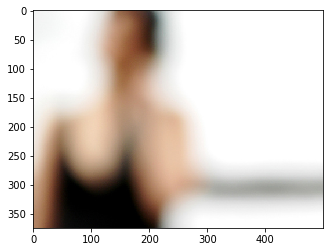

gt - circular scattering, predicted - Gauss (0.7653652)


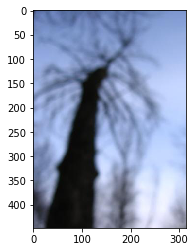

gt - circular scattering, predicted - Gauss (0.7584601)


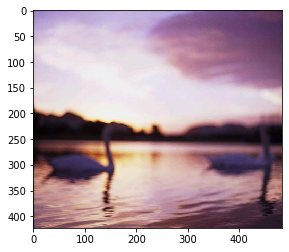

gt - circular scattering, predicted - None (0.99960643)


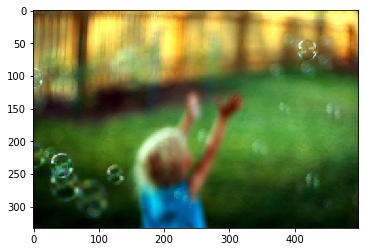

gt - circular scattering, predicted - None (0.90348023)


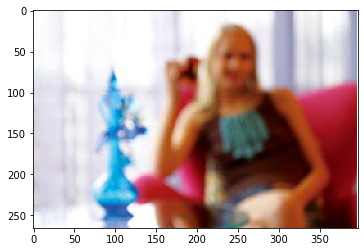

gt - circular scattering, predicted - None (0.9302515)


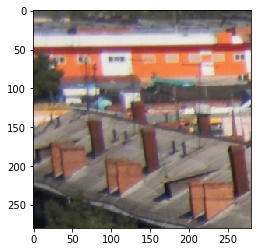

gt - circular scattering, predicted - linear smearing (0.49390447)


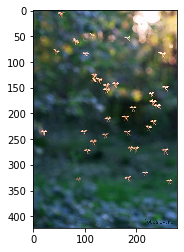

gt - circular scattering, predicted - None (1.0)
Processing directory 'linear smearing'


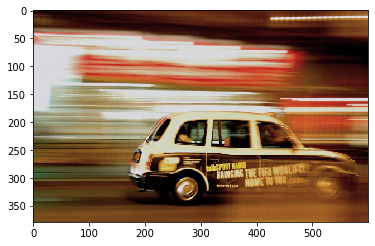

gt - linear smearing, predicted - None (0.9418859)


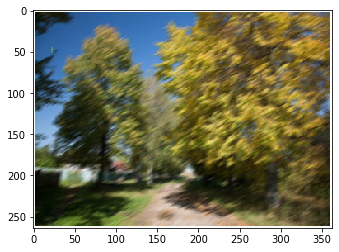

gt - linear smearing, predicted - circular scattering (0.95268685)


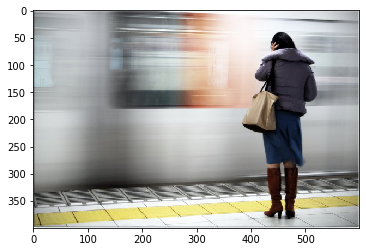

gt - linear smearing, predicted - None (0.5950182)


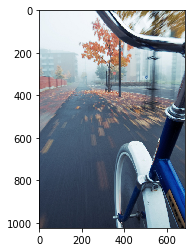

gt - linear smearing, predicted - None (0.99933726)


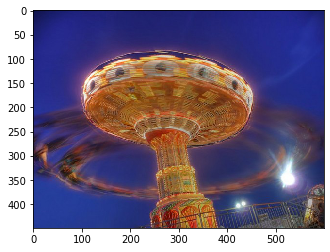

gt - linear smearing, predicted - None (0.9999881)


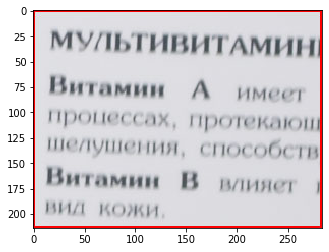

gt - linear smearing, predicted - linear smearing (0.94635415)


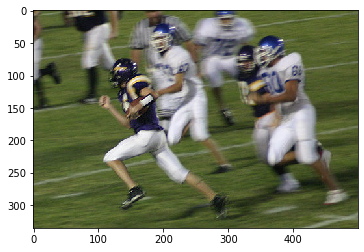

gt - linear smearing, predicted - None (0.7552914)


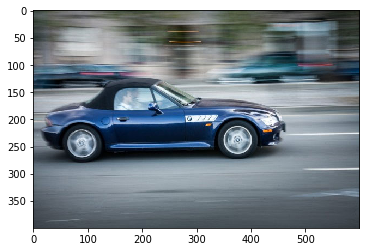

gt - linear smearing, predicted - None (0.9974138)


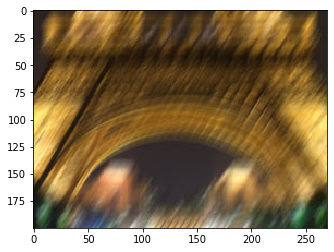

gt - linear smearing, predicted - Gauss (0.8539518)


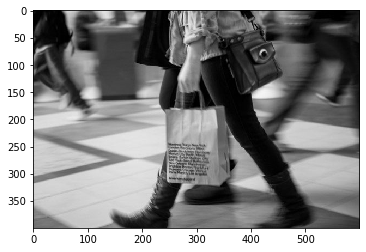

gt - linear smearing, predicted - None (0.8258068)


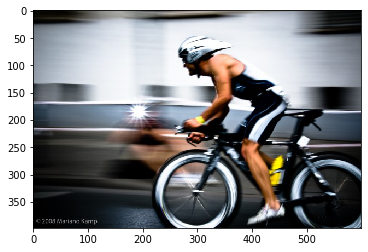

gt - linear smearing, predicted - None (0.99983037)


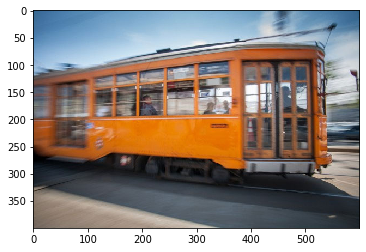

gt - linear smearing, predicted - None (0.92093194)


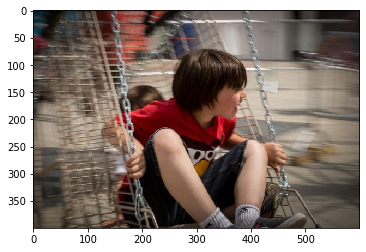

gt - linear smearing, predicted - None (0.9276454)


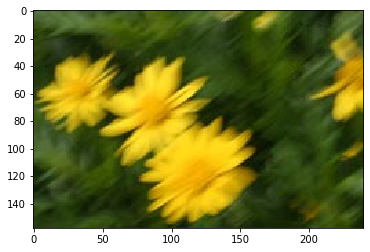

gt - linear smearing, predicted - circular scattering (0.5277189)
accuracy = 0.047619047619047616


In [0]:
predictions_dict = {}
predictions_dict['Gauss'] = 0
predictions_dict['linear smearing'] = 0
predictions_dict['circular scattering'] = 0
predictions_dict['None'] = 0
array_of_classes = np.array(['Gauss', 'None', 'circular scattering', 'linear smearing'])
total_num = 0
num_of_success = 0
dir_for_test_images = '/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_circluar_scattering'
for dir_ in os.listdir(dir_for_test_images):
  if dir_.find('.') == -1:
    print('Processing directory \''+ dir_+'\'')
    for filename in os.listdir(dir_for_test_images+'/'+dir_):
      # print(dir_for_test_images+'/'+dir_+'/'+filename)
      image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir_+'/'+filename).convert('RGB')
      image_PIL = image_PIL.resize((224,224))
      image_cv = np.array(image_PIL)
      image_cv = (image_cv / 255).astype('float')
      image_cv_4_dim = np.expand_dims(image_cv, axis=0)
      input_image_for_dataset = image_cv_4_dim
      prediction = model.predict(input_image_for_dataset)
      class_predicted = array_of_classes[[prediction == np.max(prediction[0])][0][0]][0]
      total_num += 1
      image = imread(dir_for_test_images+'/'+dir_+'/'+filename)
      pylab.imshow(gray2rgb(image))
      plt.show()
      print('gt - '+dir_+', predicted - '+class_predicted+' ('+str(np.max(prediction[0]))+')')
      if class_predicted == dir_:
        num_of_success += 1
        predictions_dict[class_predicted] += 1
print('accuracy = '+str(num_of_success/total_num))

In [0]:
dir_for_test_images = '/content/drive/My Drive/Datasets/Naturally blurred images'
for dir_ in os.listdir(dir_for_test_images):
  if dir_.find('.') == -1:
    for filename in os.listdir(dir_for_test_images+'/'+dir_):
      image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir_+'/'+filename).convert('RGB')
      image_PIL = image_PIL.resize((512,512))
      image_cv = np.array(image_PIL)
      image_gray = rgb2gray(image_cv)
      imsave('/content/drive/My Drive/Datasets/Naturally blurred images/for Irbis analyze/'+filename+'_resized_gray.bmp',image_gray)

## Checking regression

### circular regression

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

keras.metrics.mean_relative_error = mean_relative_error
keras.losses.mean_relative_error = mean_relative_error

In [0]:
filename_model = '/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_circular_scattering/resnet34/weights-resnet34-blur-regression-circular-scattering-84-val_mean_relative_error-1.82.hdf5'
model = load_model(filename_model)

In [0]:
predictions = {}
dir_for_test_images = '/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_circular_scattering'
for dir_ in tqdm_notebook(os.listdir(dir_for_test_images)):
  if dir_.find('.') != -1:
    continue
  if dir_.find('resnet') != -1:
    continue
  if dir_.find('resnext') != -1:
    continue
  if dir_.find('logs') != -1:
    continue
  if dir_.find('.') == -1:
    print('Processing directory \''+ dir_+'\'')
    for filename in os.listdir(dir_for_test_images+'/'+dir_):
      key = float(filename.split('_')[-2])
      if key < 5:
        continue
      image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir_+'/'+filename).convert('L')
      image_PIL = image_PIL.resize((512,512))
      image_cv = np.array(image_PIL)
      image_cv = (image_cv / 255).astype('float')
      image_cv_3_dim = np.expand_dims(image_cv, axis=2)
      image_cv_4_dim = np.expand_dims(image_cv_3_dim, axis=0)
      input_image_for_dataset = image_cv_4_dim
      prediction = model.predict(input_image_for_dataset)
      key = filename.split('_')[-2]
      if key in predictions.keys():
        predictions[key].append(prediction[0][0])
      else:
        predictions[key] = [prediction[0][0]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Processing directory 'DSC_2397_1_1536_1024'
Processing directory 'DSC_2397_1_1536_2048'
Processing directory 'DSC_2397_1_1536_1536'
Processing directory 'DSC_2397_1_1536_3584'
Processing directory 'DSC_2397_2_0_3072'
Processing directory 'DSC_2397_1_1536_2560'
Processing directory 'DSC_2397_1_1536_4096'
Processing directory 'DSC_2397_1_1536_3072'
Processing directory 'DSC_2397_3_1536_1536'
Processing directory 'DSC_2571_1_1024_0'
Processing directory 'DSC_2571_1_1024_512'
Processing directory 'DSC_2571_1_1024_1536'
Processing directory 'DSC_2571_1_1024_1024'
Processing directory 'DSC_2571_1_1024_3584'
Processing directory 'Dsc_2027_1_1024_2560'
Processing directory 'DSC_2571_1_1024_2048'
Processing directory 'DSC_2571_1_1024_3072'
Processing directory 'DSC_2571_1_1024_2560'
Processing directory 'Dsc_2027_1_1024_2048'
Processing directory 'DSC_2571_1_1024_4096'
Processing directory 'Dsc_2027_1_2560_1536'
Processing directory 'Dsc_2027_1_2560_2048'
Processing directory 'DSC_2397_1_0_4096

IndexError: ignored

In [0]:
for key in predictions.keys():
  predictions[key] = list(map(float,predictions[key]))

In [0]:
import json

output_filename = dir_for_test_images+'/'+filename_model.split('/')[-1]
output_filename = output_filename[:output_filename.rfind('.')]+'.json'
print(output_filename)
with open(output_filename, 'w') as f:
    json.dump(predictions, f)

In [0]:
# Relative error distribution

import matplotlib.pylab as plt

relative_errors = []
for key in predictions.keys():
  relative_errors.extend(100*abs(np.array(predictions[key])-np.array([float(key)]*len(predictions[key])))/float(key))
plt.xlabel('Относительаая ошибка')
plt.ylabel('Количество')
plt.hist(relative_errors, bins=30, color='black')

In [0]:
# Error dependence from true value
true_values = []
mean_errors = []
for key in predictions.keys():
  true_values.append(float(key))
  array_of_errors = 100*abs(np.array(predictions[key])-np.array([float(key)]*len(predictions[key])))/float(key)
  mean_errors.append(np.sum(array_of_errors)/len(array_of_errors))
plt.plot(true_values, mean_errors), c='black')
x = np.linspace(min(true_values),(true_values),10)
xi = list(range(len(x)))
# plt.xticks(xi, x)
plt.show()

### Gauss blur

In [0]:
from keras.models import load_model
import os
import PIL
from keras.utils.generic_utils import get_custom_objects
import keras.metrics
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

# from __future__ import division

import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape

from keras import backend as K
import keras

Using TensorFlow backend.


In [0]:
a= []
while True:
  a.append('1')

KeyboardInterrupt: ignored

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

keras.metrics.mean_relative_error = mean_relative_error
keras.losses.mean_relative_error = mean_relative_error

In [0]:
def activation_function_log(x):
    return K.abs(x)

class Class_Activation_log(Activation):
    def __init__(self, activation, **kwargs):
        super(Class_Activation_log, self).__init__(activation, **kwargs)
        self.__name__ = 'Activation_log'

get_custom_objects().update({'Activation_log': Class_Activation_log(activation_function_log)})

In [0]:
filename_model = '/content/drive/My Drive/Datasets/Spectres_of_Gauss_blurred_Chochia_images_0_1/weights-resnet18-Gauss-blur-regression-0-1-84-val_mean_relative_error-40.17.hdf5'
model = load_model(filename_model)

In [0]:
def get_pic_FT(_image):
  F_image = np.fft.fft(np.reshape(_image,(1,-1)))
  temp_F = np.copy(F_image)
  temp_F = np.reshape(temp_F, _image.shape)
  temp = np.zeros(temp_F.shape, dtype=float)
  temp = np.reshape(temp, _image.shape)
  for i in range(temp_F.shape[0]):
    k = i + temp_F.shape[0] // 2
    if k > (temp_F.shape[0]-1): k = i - temp_F.shape[0] // 2
    for j in range(temp_F.shape[1]):
      l = j + temp_F.shape[1] // 2
      if l > (temp_F.shape[1]-1): l = j - temp_F.shape[1] // 2
      temp[i][j] = abs(temp_F[k][l])
  return temp

In [0]:
predictions = {}
dir_for_test_images = '/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_Gauss_blurr_for_validation_1'
for dir_ in tqdm_notebook(os.listdir(dir_for_test_images)):
  if dir_.find('.') == -1:
    print('Processing directory \''+ dir_+'\'')
    for filename in os.listdir(dir_for_test_images+'/'+dir_):
      key = filename.split('_')[-2]
      if float(key) >1:
        continue
      image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir_+'/'+filename).convert('L')
      image_cv = np.array(image_PIL)
      spectre = get_pic_FT(image_cv)
      spectre = np.reshape(spectre,(-1))
      for i in range(len(spectre)):
        if spectre[i] != 0:
          spectre[i] = math.log(spectre[i])
      spectre = (spectre - np.min(spectre))/(np.max(spectre)-np.min(spectre))
      spectre = np.reshape(spectre,image_cv.shape)
      spectre = spectre[128:384,128:384]
      spectre = spectre.astype('float')
      spectre_3_dim = np.expand_dims(spectre, axis=2)
      spectre_4_dim = np.expand_dims(spectre_3_dim, axis=0)
      input_image_for_dataset = spectre_4_dim
      prediction = model.predict(input_image_for_dataset)
      if key in predictions.keys():
        predictions[key].append(prediction[0][0])
      else:
        predictions[key] = [prediction[0][0]]

In [0]:
for key in predictions.keys():
  predictions[key] = list(map(float,predictions[key]))
  
import json

output_filename = dir_for_test_images+'/'+filename_model.split('/')[-1]
output_filename = output_filename[:output_filename.rfind('.')]+'.json'
print(output_filename)
with open(output_filename, 'w') as f:
    json.dump(predictions, f)

/content/drive/My Drive/Datasets/Blurred_Chochia_images_with_Gauss_blurr_for_validation_1/weights-resnet18-Gauss-blur-regression-0-1-84-val_mean_relative_error-40.17.json


(array([ 9., 12., 19., 29., 47., 56., 59., 53., 45., 38., 38.,  5.,  5.,
         4.,  5.,  4.,  5.,  5.,  6., 11., 11., 11., 15., 23., 18., 17.,
        23., 28., 24., 23., 26., 18., 30., 17., 23., 23., 17., 12., 15.,
         9.,  7.,  5.,  5.,  7.,  4.,  4.,  1.,  4.,  1.,  3.,  2.,  1.,
         1.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([3.44613194e-04, 9.51723434e-03, 1.86898555e-02, 2.78624766e-02,
        3.70350978e-02, 4.62077189e-02, 5.53803401e-02, 6.45529612e-02,
        7.37255824e-02, 8.28982035e-02, 9.20708246e-02, 1.01243446e-01,
        1.10416067e-01, 1.19588688e-01, 1.28761309e-01, 1.37933930e-01,
        1.47106552e-01, 1.56279173e-01, 1.65451794e-01, 1.74624415e-01,
        1.83797036e-01, 1.92969657e-01, 2.02142278e-01, 2.11314900e-01,
  

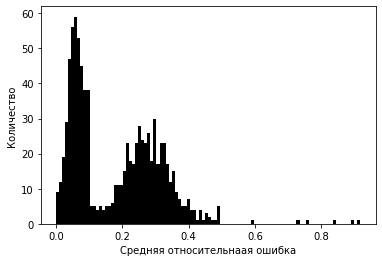

In [0]:
# Relative error distribution

import matplotlib.pylab as plt

relative_errors = []
for key in predictions.keys():
  relative_errors.extend(abs(np.array(predictions[key])-np.array([float(key)]*len(predictions[key]))))
plt.xlabel('Средняя относительная ошибка')
plt.ylabel('Количество')
plt.hist(relative_errors, bins=100, color='black')

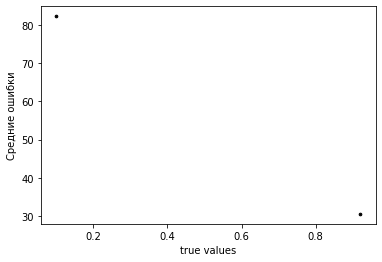

In [0]:
# Error dependence from true value
true_values = []
mean_errors = []
for key in predictions.keys():
  true_values.append(float(key))
  array_of_errors = 100*abs(np.array(predictions[key])-np.array([float(key)]*len(predictions[key])))/float(key)
  mean_errors.append(np.sum(array_of_errors)/len(array_of_errors))
plt.scatter(true_values, mean_errors, c='black', s= 7)
# x = np.linspace(min(true_values),(true_values),10)
# xi = list(range(len(x)))
# # plt.xticks(xi, x)
plt.xlabel('true values')
plt.ylabel('Средние ошибки')
plt.show()

In [0]:
sum(array_of_errors)/len(array_of_errors)

30.563977506478796

### linear smearing

In [0]:
from keras.models import load_model
import os
import PIL
from keras.utils.generic_utils import get_custom_objects
import keras.metrics
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

# from __future__ import division

import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape

from keras import backend as K
import keras

Using TensorFlow backend.


In [0]:
def activation_function_cos(x):
    return K.abs(x)

class Class_Activation_cos(Activation):
    def __init__(self, activation, **kwargs):
        super(Class_Activation_cos, self).__init__(activation, **kwargs)
        self.__name__ = 'Activation_log'

get_custom_objects().update({'Activation_log': Class_Activation_cos(activation_function_cos)})

In [0]:
def mean_relative_error(y_true, y_pred):
    result = 100*(K.abs(y_true - y_pred))/y_true
    return K.mean(result)

keras.metrics.mean_relative_error = mean_relative_error
keras.losses.mean_relative_error = mean_relative_error

In [0]:
def get_pic_FT(_image):
  F_image = np.fft.fft(np.reshape(_image,(1,-1)))
  temp_F = np.copy(F_image)
  temp_F = np.reshape(temp_F, _image.shape)
  temp = np.zeros(temp_F.shape, dtype=float)
  temp = np.reshape(temp, _image.shape)
  for i in range(temp_F.shape[0]):
    k = i + temp_F.shape[0] // 2
    if k > (temp_F.shape[0]-1): k = i - temp_F.shape[0] // 2
    for j in range(temp_F.shape[1]):
      l = j + temp_F.shape[1] // 2
      if l > (temp_F.shape[1]-1): l = j - temp_F.shape[1] // 2
      temp[i][j] = abs(temp_F[k][l])
  return temp

In [0]:
filename_model = '/content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images/weights-resnet18-blur-regression-radius-linear-smearing-68-2.83(filter>5).hdf5'
model = load_model(filename_model)

In [0]:
predictions = {}
dir_for_test_images = '/content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images'
for dir_ in tqdm_notebook(os.listdir(dir_for_test_images)):
  if (dir_.find('resnet') != -1) or (dir_.find('resnext') != -1):
    continue
  if dir_.find('logs') != -1:
    continue
  if dir_.find('.') == -1:
    print('Processing directory \''+ dir_+'\'')
    for filename in os.listdir(dir_for_test_images+'/'+dir_):
      key_length = float(filename.split('_')[-2])
      if key_length < 5:
        continue
      image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir_+'/'+filename).convert('L')
      image_cv = np.array(image_PIL)
      #spectre = get_pic_FT(image_cv)
      #spectre = cv2.resize(spectre, (256,256))
      #spectre = np.reshape(spectre,(-1))
      #for i in range(len(spectre)):
      #  if spectre[i] != 0:
      #    spectre[i] = math.log(spectre[i])
      spectre = (image_cv / 255).astype('float')
      #spectre = np.reshape(spectre,(256,256))
      spectre_3_dim = np.expand_dims(spectre, axis=2)
      spectre_4_dim = np.expand_dims(spectre_3_dim, axis=0)
      input_image_for_dataset = spectre_4_dim
      prediction = model.predict(input_image_for_dataset)
      key_length = filename.split('_')[-2]
      if key_length in predictions.keys():
        predictions[key_length].append(prediction[0][0])
      else:
        predictions[key_length] = [prediction[0][0]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Processing directory 'DSC_3289_2_2048_2048'


In [0]:
for key in predictions.keys():
  predictions[key] = list(map(float,predictions[key]))
  
import json

output_filename = dir_for_test_images+'/'+filename_model.split('/')[-1]
output_filename = output_filename[:output_filename.rfind('.')]+'.json'
print(output_filename)
with open(output_filename, 'w') as f:
    json.dump(predictions, f)

In [0]:
# Relative error distribution

import matplotlib.pylab as plt

relative_errors = []
for key in predictions.keys():
  relative_errors.extend(abs(np.array(predictions[key])-np.array([float(key)]*len(predictions[key]))))
plt.xlabel('Средняя относительная ошибка')
plt.ylabel('Количество')
plt.hist(relative_errors, bins=100, color='black')

In [0]:
# Error dependence from true value
true_values = []
mean_errors = []
for key in predictions.keys():
  true_values.append(float(key))
  array_of_errors = 100*abs(np.array(predictions[key])-np.array([float(key)]*len(predictions[key])))/float(key)
  mean_errors.append(np.sum(array_of_errors)/len(array_of_errors))
plt.scatter(true_values, mean_errors, c='black', s= 7)
# x = np.linspace(min(true_values),(true_values),10)
# xi = list(range(len(x)))
# # plt.xticks(xi, x)
plt.xlabel('true values')
plt.ylabel('Средние ошибки')
plt.show()

In [0]:
sum(mean_errors)/len(mean_errors)

### Checking angle prediction

In [0]:
from keras.models import load_model
import os
import PIL
from keras.utils.generic_utils import get_custom_objects
import keras.metrics
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

# from __future__ import division

import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape

from keras import backend as K
import keras

In [0]:
def get_pic_FT(_image):
  F_image = np.fft.fft(np.reshape(_image,(1,-1)))
  temp_F = np.copy(F_image)
  temp_F = np.reshape(temp_F, _image.shape)
  temp = np.zeros(temp_F.shape, dtype=float)
  temp = np.reshape(temp, _image.shape)
  for i in range(temp_F.shape[0]):
    k = i + temp_F.shape[0] // 2
    if k > (temp_F.shape[0]-1): k = i - temp_F.shape[0] // 2
    for j in range(temp_F.shape[1]):
      l = j + temp_F.shape[1] // 2
      if l > (temp_F.shape[1]-1): l = j - temp_F.shape[1] // 2
      temp[i][j] = abs(temp_F[k][l])
  return temp

In [0]:
def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    x = K.argmax(y_true)
    y = K.argmax(y_pred)
    diff = 90 - abs(abs(x - y) - 90)
    return K.mean(K.cast(K.abs(diff), K.floatx()))

keras.metrics.angle_error = angle_error

In [0]:
filename_model = '/content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images/weights-resnet18-linear-blur-regression-alpha-13-val_angle_error-8.48.hdf5'
model = load_model(filename_model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
class_indices = {'-1.0': 0,
 '-10.0': 1,
 '-11.0': 2,
 '-12.0': 3,
 '-13.0': 4,
 '-14.0': 5,
 '-15.0': 6,
 '-16.0': 7,
 '-17.0': 8,
 '-18.0': 9,
 '-19.0': 10,
 '-2.0': 11,
 '-20.0': 12,
 '-21.0': 13,
 '-22.0': 14,
 '-23.0': 15,
 '-24.0': 16,
 '-25.0': 17,
 '-26.0': 18,
 '-27.0': 19,
 '-28.0': 20,
 '-29.0': 21,
 '-3.0': 22,
 '-30.0': 23,
 '-31.0': 24,
 '-32.0': 25,
 '-33.0': 26,
 '-34.0': 27,
 '-35.0': 28,
 '-36.0': 29,
 '-37.0': 30,
 '-38.0': 31,
 '-39.0': 32,
 '-4.0': 33,
 '-40.0': 34,
 '-41.0': 35,
 '-42.0': 36,
 '-43.0': 37,
 '-44.0': 38,
 '-45.0': 39,
 '-46.0': 40,
 '-47.0': 41,
 '-48.0': 42,
 '-49.0': 43,
 '-5.0': 44,
 '-50.0': 45,
 '-51.0': 46,
 '-52.0': 47,
 '-53.0': 48,
 '-54.0': 49,
 '-55.0': 50,
 '-56.0': 51,
 '-57.0': 52,
 '-58.0': 53,
 '-59.0': 54,
 '-6.0': 55,
 '-60.0': 56,
 '-61.0': 57,
 '-62.0': 58,
 '-63.0': 59,
 '-64.0': 60,
 '-65.0': 61,
 '-66.0': 62,
 '-67.0': 63,
 '-68.0': 64,
 '-69.0': 65,
 '-7.0': 66,
 '-70.0': 67,
 '-71.0': 68,
 '-72.0': 69,
 '-73.0': 70,
 '-74.0': 71,
 '-75.0': 72,
 '-76.0': 73,
 '-77.0': 74,
 '-78.0': 75,
 '-79.0': 76,
 '-8.0': 77,
 '-80.0': 78,
 '-81.0': 79,
 '-82.0': 80,
 '-83.0': 81,
 '-84.0': 82,
 '-85.0': 83,
 '-86.0': 84,
 '-87.0': 85,
 '-88.0': 86,
 '-89.0': 87,
 '-9.0': 88,
 '0.0': 89,
 '1.0': 90,
 '10.0': 91,
 '11.0': 92,
 '12.0': 93,
 '13.0': 94,
 '14.0': 95,
 '15.0': 96,
 '16.0': 97,
 '17.0': 98,
 '18.0': 99,
 '19.0': 100,
 '2.0': 101,
 '20.0': 102,
 '21.0': 103,
 '22.0': 104,
 '23.0': 105,
 '24.0': 106,
 '25.0': 107,
 '26.0': 108,
 '27.0': 109,
 '28.0': 110,
 '29.0': 111,
 '3.0': 112,
 '30.0': 113,
 '31.0': 114,
 '32.0': 115,
 '33.0': 116,
 '34.0': 117,
 '35.0': 118,
 '36.0': 119,
 '37.0': 120,
 '38.0': 121,
 '39.0': 122,
 '4.0': 123,
 '40.0': 124,
 '41.0': 125,
 '42.0': 126,
 '43.0': 127,
 '44.0': 128,
 '45.0': 129,
 '46.0': 130,
 '47.0': 131,
 '48.0': 132,
 '49.0': 133,
 '5.0': 134,
 '50.0': 135,
 '51.0': 136,
 '52.0': 137,
 '53.0': 138,
 '54.0': 139,
 '55.0': 140,
 '56.0': 141,
 '57.0': 142,
 '58.0': 143,
 '59.0': 144,
 '6.0': 145,
 '60.0': 146,
 '61.0': 147,
 '62.0': 148,
 '63.0': 149,
 '64.0': 150,
 '65.0': 151,
 '66.0': 152,
 '67.0': 153,
 '68.0': 154,
 '69.0': 155,
 '7.0': 156,
 '70.0': 157,
 '71.0': 158,
 '72.0': 159,
 '73.0': 160,
 '74.0': 161,
 '75.0': 162,
 '76.0': 163,
 '77.0': 164,
 '78.0': 165,
 '79.0': 166,
 '8.0': 167,
 '80.0': 168,
 '81.0': 169,
 '82.0': 170,
 '83.0': 171,
 '84.0': 172,
 '85.0': 173,
 '86.0': 174,
 '87.0': 175,
 '88.0': 176,
 '89.0': 177,
 '9.0': 178,
 '90.0': 179}

In [0]:
indices_classes = {v: k for k, v in class_indices.items()}

In [0]:
predictions_angle = {}
dir_for_test_images = '/content/drive/My Drive/Datasets/Spectres_of_linear_blurred_Chochia_images'
for dir_ in tqdm_notebook(os.listdir(dir_for_test_images)):
  if dir_.find('.') == -1:
    print('Processing directory \''+ dir_+'\'', flush=True)
    for filename in os.listdir(dir_for_test_images+'/'+dir_):
      try:
        image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir_+'/'+filename).convert('L')
      except:
        continue
      image_cv = np.array(image_PIL)
      # spectre = get_pic_FT(image_cv)
      # spectre = cv2.resize(spectre, (256,256))
      # spectre = np.reshape(spectre,(-1))
      # for i in range(len(spectre)):
      #   if spectre[i] != 0:
      #     spectre[i] = math.log(spectre[i])
      spectre = (image_cv / 255).astype('float')
      spectre = np.reshape(spectre, image_cv.shape)
      spectre_3_dim = np.expand_dims(spectre, axis=2)
      spectre_4_dim = np.expand_dims(spectre_3_dim, axis=0)
      input_image_for_dataset = spectre_4_dim
      prediction = model.predict(input_image_for_dataset)
      predicted_angle = indices_classes[np.array(list(indices_classes.keys()))[prediction[0] == np.max(prediction[0])][0]]
      key_angle = filename.split('_')[-1]
      key_angle = key_angle[:key_angle.rfind('.')]
      if key_angle in predictions_angle.keys():
        predictions_angle[key_angle].append(predicted_angle)
      else:
        predictions_angle[key_angle] = [predicted_angle]

In [0]:
for key in predictions_angle.keys():
  predictions_angle[key] = list(map(float,predictions_angle[key]))

In [0]:
import json

output_filename = dir_for_test_images+'/'+filename_model.split('/')[-1]
output_filename = output_filename[:output_filename.rfind('.')]+'.json'
with open(output_filename, 'w') as f:
    json.dump(predictions_angle, f)

In [0]:
import matplotlib.pylab as plt

errors = []
for key in predictions_angle.keys():
  errors.extend(abs(np.array(predictions_angle[key])-np.array([float(key)]*len(predictions_angle[key]))))
plt.xlabel('Ошибка')
plt.ylabel('Количество')
plt.hist(errors, bins=30)